# NIHAO_preparation

A tool to convert raw NIHAO simulation output into 1 single FITS file for stars and 1 for gas.
The simulation is repositioned and rotate to center face on on the main halo.
Important properties are converted both into physical units (e.g. Age in Gyr, velocity in km/s).
Elemental abundanes are reported as logarithmic number density ratios, consistent with Galactic spectroscopy.

#### Github Repository

https://www.github.com/svenbuder/preparing_NIHAO

#### Author:
Sven Buder (ANU, sven.buder@anu.edu.au)

#### Initial Data:
NIHAO-UHD simulations, see:  
Buck 2020: https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.5435B  
Buck et al. 2020b: https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.3461B  
Buck et al. 2021: https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B  
Buck et al. 2023: https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.1565B  
Buder, Mijnarends, and Buck 2024: https://ui.adsabs.harvard.edu/abs/2024arXiv240413835B  

In [39]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# general packages
import numpy as np
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo
import glob
from pathlib import Path

# pynbody
import pynbody as pb
from pynbody.snapshot.tipsy import TipsySnap

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [
    'a)','b)','c)',
    'd)','e)','f)',
    'g)','h)','i)',
    'j)','k)','l)',
    'm)','n)','o)',
    'q)','r)','s)',
    't)','u)','v)',
    'w)','x)','y)',
    'z)','aa)','ab)',
    'ac)','ad)','ae)'
]

# # Creating colormaps that trace Kobayashi, Karakas, and Lugaro (2020)
# # https://ui.adsabs.harvard.edu/abs/2020ApJ...900..179K
# for name, color in zip(['K20_Blues','K20_Reds','K20_Greens','K20_Blacks','K20_pink'],['#9AA2C3', '#DD9877', '#C8DAB2','#2A2A2A','#CBA9C5']):
#     plt.register_cmap(name=name, cmap = LinearSegmentedColormap.from_list(name, ['#ffffff', color]))

In [30]:
# Adjust this for your simulation.
# Files are expexted in 'NIHAO_raw/'+simulation_name+'/'+simulation_mass+'.'+simulation_snapshot

# simulation_name = 'g8.26e11_pilot' # this is the first run of this simulation with abundances
simulation_name = 'g8.26e11_extensive' # this includes more abundances!

simulation_mass = 'g8.26e11'
simulation_snapshot = '01024'

# Read in full simulation
simulation_path = 'NIHAO_raw/'+simulation_name+'/'+simulation_mass+'.'+simulation_snapshot
print('Reading in '+simulation_path)
simulation_full = pb.load('NIHAO_raw/'+simulation_name+'/'+simulation_mass+'.'+simulation_snapshot)

Reading in NIHAO_raw/g8.26e11_extensive/g8.26e11.01024


# 1. Simulation vs. Main Halo (Dark Matter, Stars, Gas)

In [31]:
# Get an idea of how many halos have been identified in the simulation
simulation_halos = simulation_full.halos()
main_halo = simulation_halos[1]

pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


In [32]:
def hist2d_darkmatter_stars_gas(simulation, frame = 'xy', effective_radius = False, bins = 200, saveas=False):
    
    if frame == 'xy':
        pos_1 = 0
        pos_2 = 1
    elif frame == 'xz':
        pos_1 = 0
        pos_2 = 2
    elif frame == 'yz':
        pos_1 = 1
        pos_2 = 2
    else:
        raise ValueError('frame has to be xy, xz, or yz!')
    
    unit = 'kpc'
    xmin = np.min(simulation.dm['pos'][:,pos_1].in_units(unit))
    if xmin < -30000:
        unit = 'Mpc'

    xmedian = np.median(simulation.dm['pos'][:,pos_1].in_units(unit))
    ymedian = np.median(simulation.dm['pos'][:,pos_2].in_units(unit))
    
    xmin = np.min(simulation.dm['pos'][:,pos_1].in_units(unit) - xmedian)
    xmax = np.max(simulation.dm['pos'][:,pos_1].in_units(unit) - xmedian)
    ymin = np.min(simulation.dm['pos'][:,pos_2].in_units(unit) - ymedian)
    ymax = np.max(simulation.dm['pos'][:,pos_2].in_units(unit) - ymedian)
    
    if effective_radius:
        xmin = -effective_radius - xmedian
        xmax = effective_radius  - xmedian
        ymin = -effective_radius - ymedian
        ymax = effective_radius  - ymedian
    
    pos = ['X','Y','Z']
    
    f, gs = plt.subplots(1,3,figsize=(12,4.5),sharex=True,sharey=True)
    ax = gs[0]
    ax.text(0.04,0.95,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_title('Dark Matter Density', fontsize=20)

    ax.hist2d(
        simulation.dm['pos'][:,pos_1].in_units(unit) - xmedian,
        simulation.dm['pos'][:,pos_2].in_units(unit) - ymedian,
        bins = (np.linspace(xmin,xmax,bins),np.linspace(ymin,ymax,bins)),
        cmin = 1, cmap = 'viridis',
        norm = LogNorm(),
    );
    ax.set_xlabel(pos[pos_1]+' / '+unit)
    ax.set_ylabel(pos[pos_2]+' / '+unit)
    
    ax = gs[1]
    ax.text(0.04,0.95,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_title('Stellar Density', fontsize=20)

    ax.hist2d(
        simulation.s['pos'][:,pos_1].in_units(unit) - xmedian,
        simulation.s['pos'][:,pos_2].in_units(unit) - ymedian,
        bins = (np.linspace(xmin,xmax,bins),np.linspace(ymin,ymax,bins)),
        cmin = 1, cmap = 'cividis',
        norm = LogNorm(),
    );
    ax.set_xlabel(pos[pos_1]+' / '+unit)
    ax.set_ylabel(pos[pos_2]+' / '+unit)
    
    ax = gs[2]
    ax.text(0.04,0.95,panels[2],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_title('Gas Density', fontsize=20)

    ax.hist2d(
        simulation.gas['pos'][:,pos_1].in_units(unit) - xmedian,
        simulation.gas['pos'][:,pos_2].in_units(unit) - ymedian,
        bins = (np.linspace(xmin,xmax,bins),np.linspace(ymin,ymax,bins)),
        cmin = 1, cmap = 'plasma',
        norm = LogNorm(),
    );
    ax.set_xlabel(pos[pos_1]+' / '+unit)
    ax.set_ylabel(pos[pos_2]+' / '+unit)
    plt.tight_layout()
    
    if saveas:
        filename = 'NIHAO_'+simulation_name+'_darkmatter_stars_gas_'+frame+'_1re.png'
        directory = 'NIHAO_prepared/NIHAO_'+simulation_name+'_diagnostic_plots/'
        Path(directory).mkdir(parents=True, exist_ok=True)
        plt.savefig(directory+filename, dpi=300, bbox_inches='tight')
        print('Saved as '+filename)
    plt.show()
    plt.close()

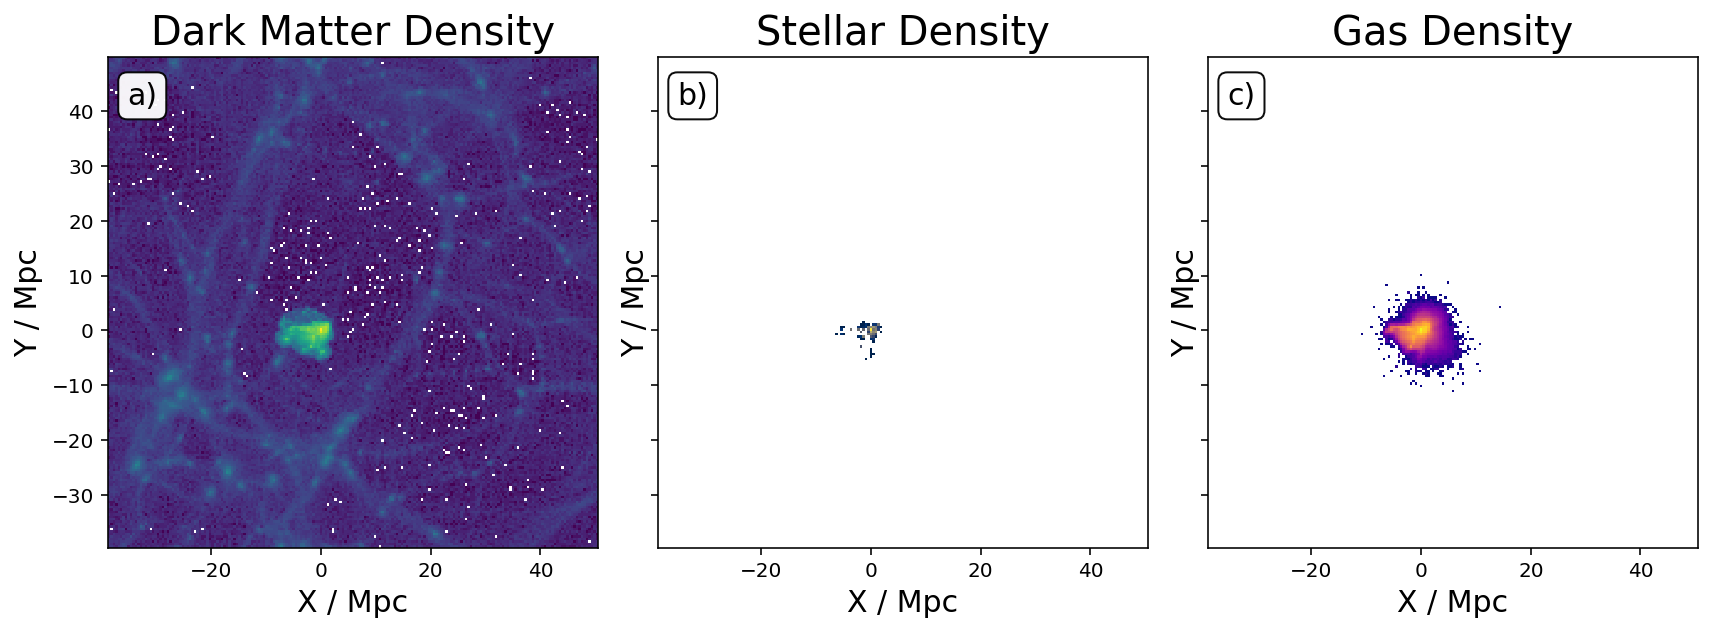

In [33]:
# Note: this is in the initial simulation frame, not yet rotated towards the main halo
hist2d_darkmatter_stars_gas(simulation_full)

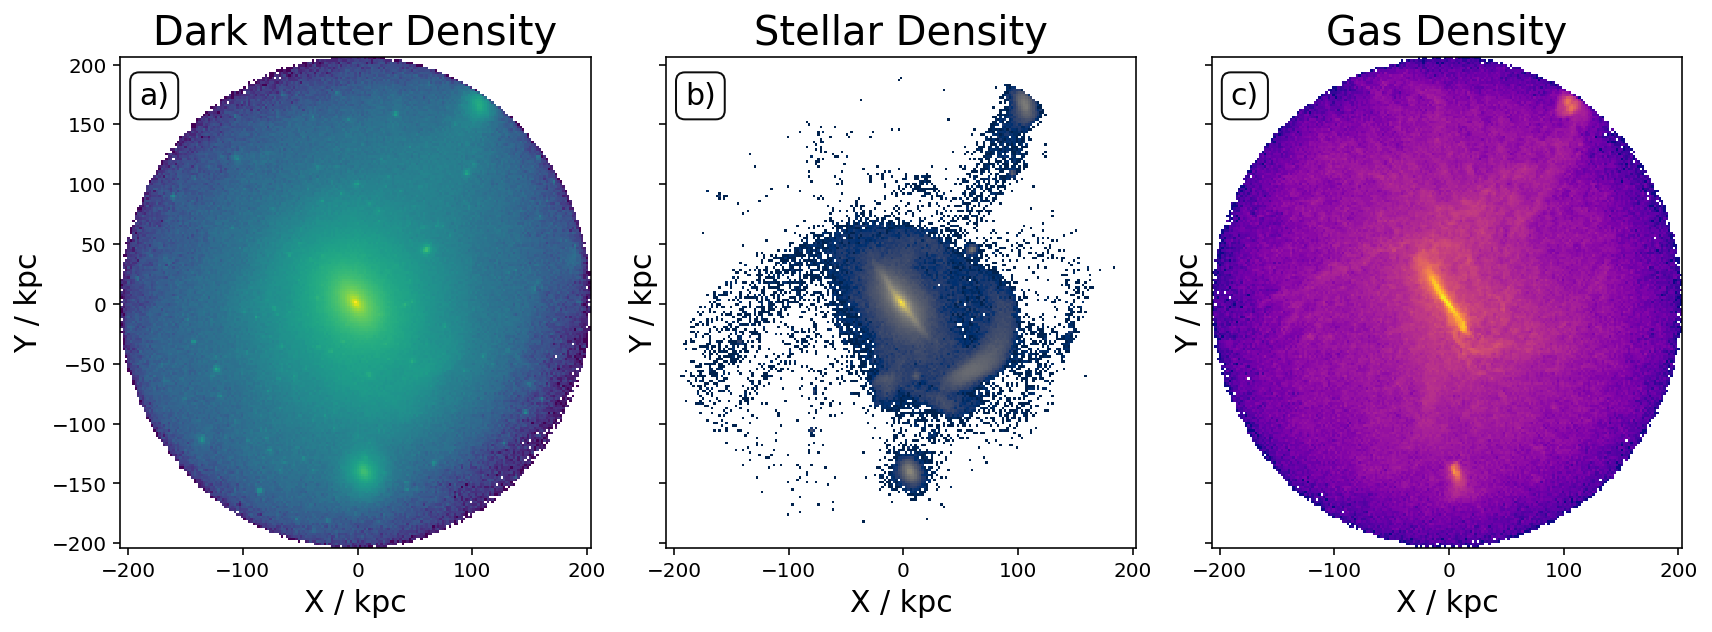

In [34]:
# Note: this is in the initial simulation frame, not yet rotated towards the main halo
hist2d_darkmatter_stars_gas(main_halo)

# 2. Coordinate Transformation towards face on Main Halo

In [35]:
# Reposition and rotate the simulation containing the main halo to see the main halo's disk face on.
pb.analysis.angmom.faceon(main_halo);

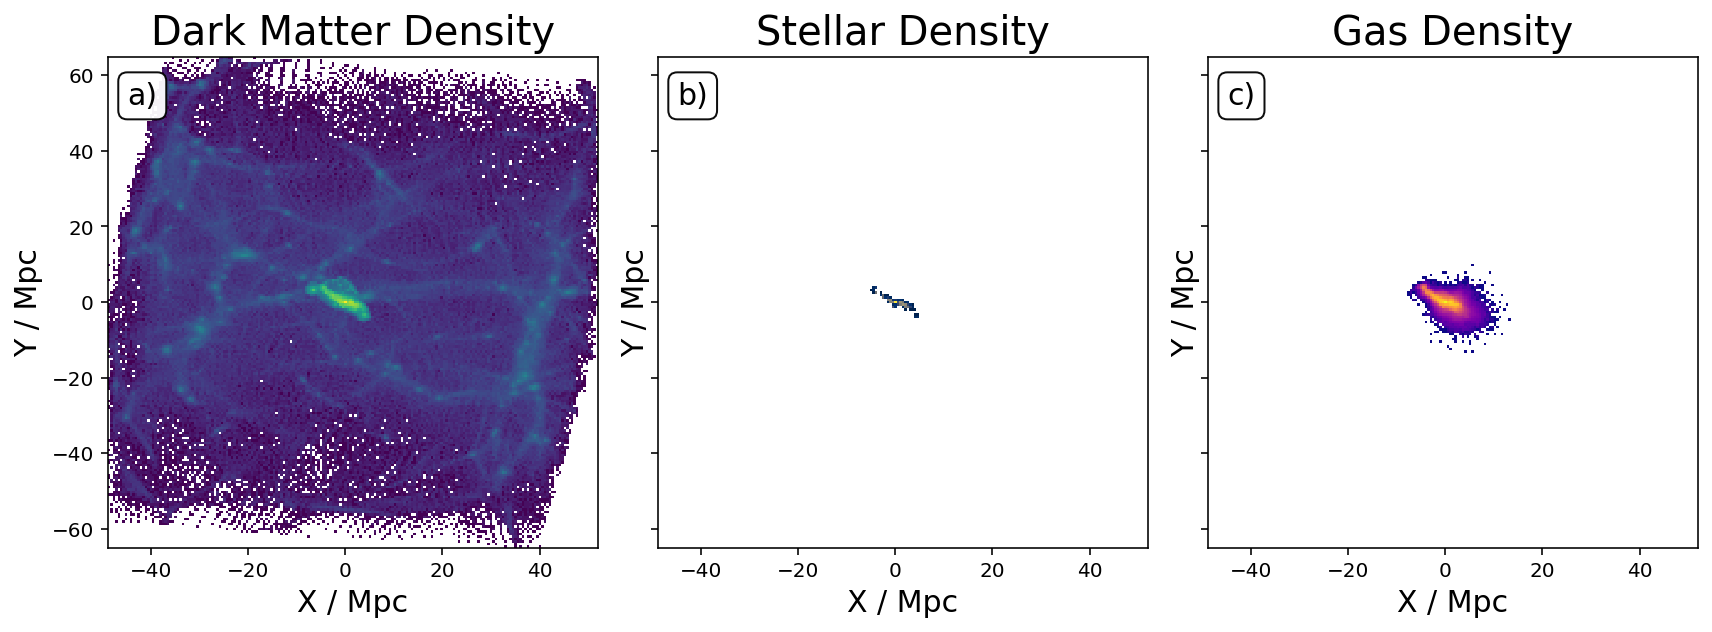

In [36]:
# How did we reposition and rotate the full simulation?
hist2d_darkmatter_stars_gas(simulation_full)

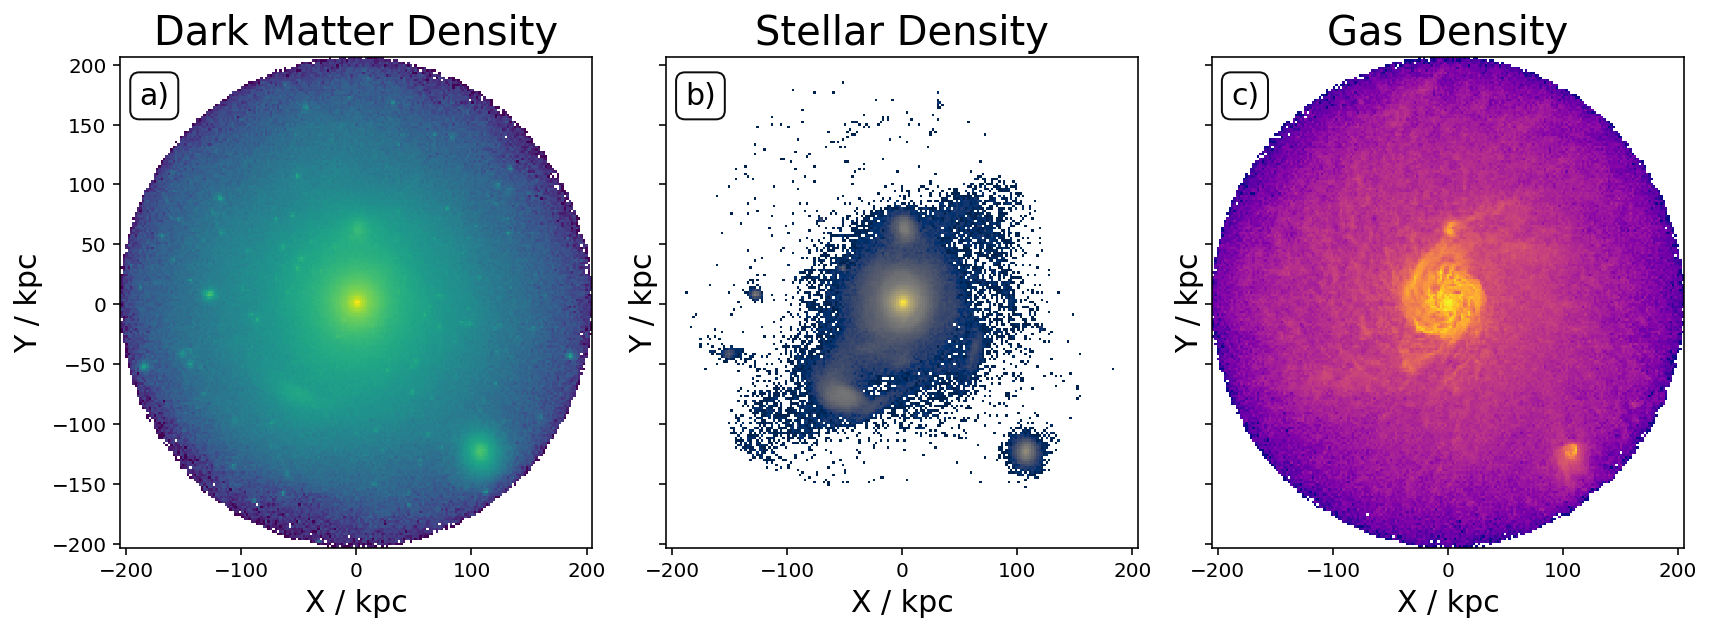

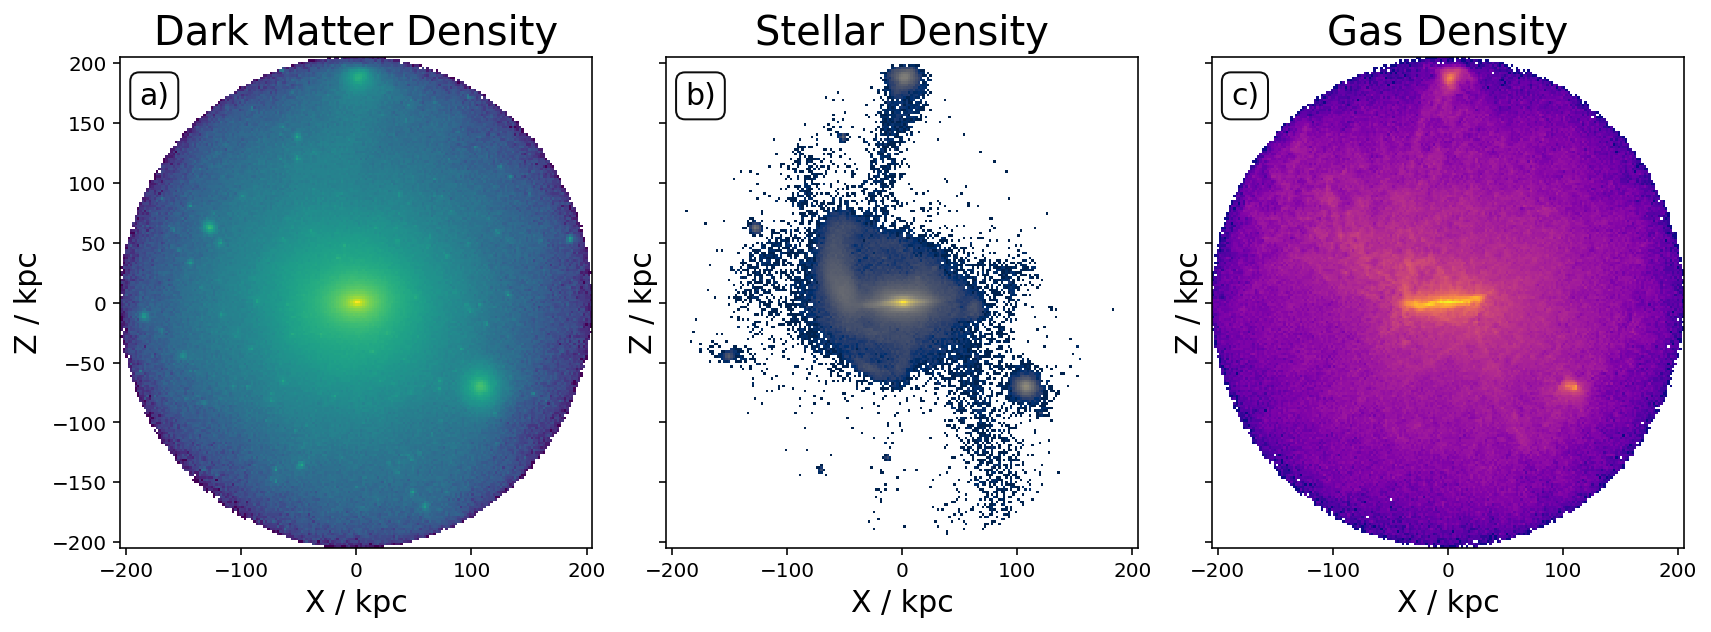

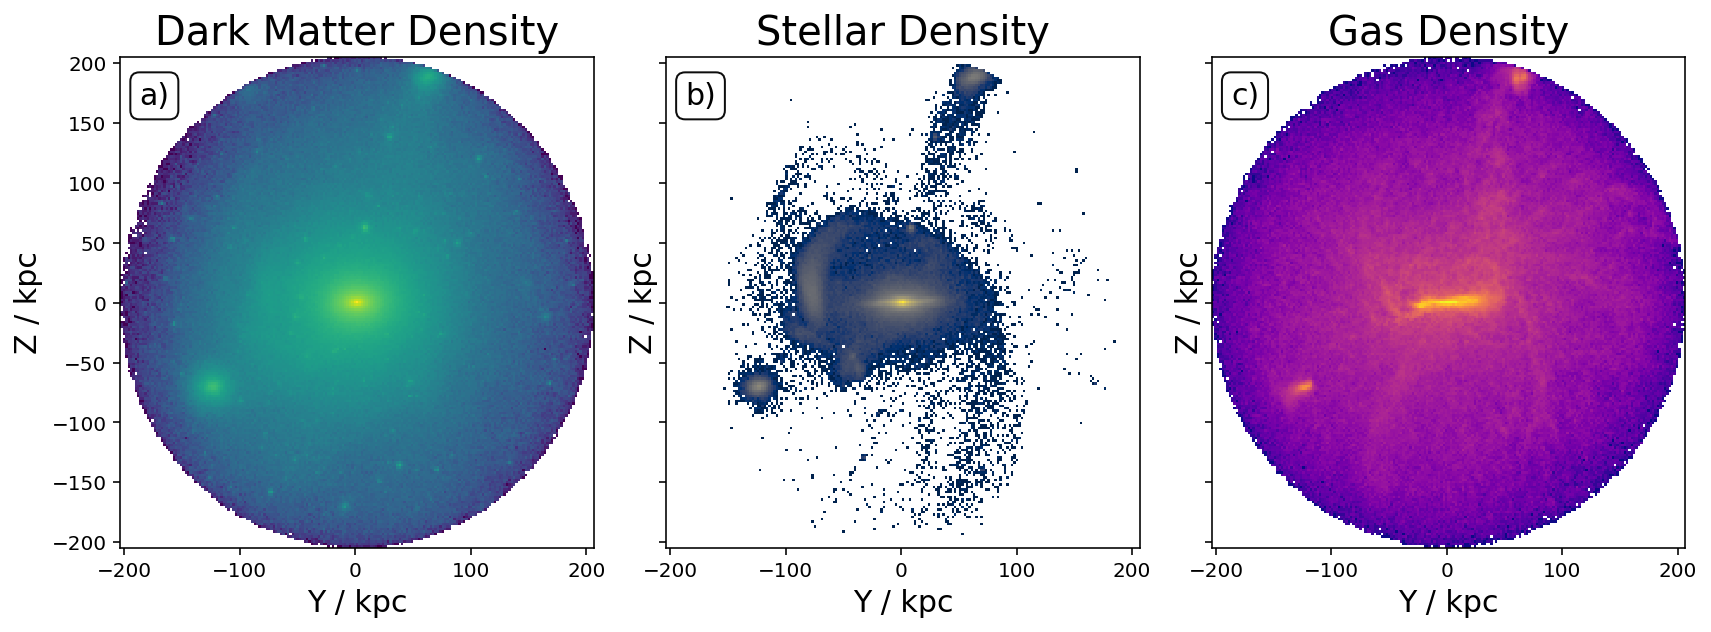

In [37]:
# Is the main halo now face on?
hist2d_darkmatter_stars_gas(main_halo, frame = 'xy')
hist2d_darkmatter_stars_gas(main_halo, frame = 'xz')
hist2d_darkmatter_stars_gas(main_halo, frame = 'yz')

In [38]:
# Calculate the total mass of the halo
total_mass = main_halo['mass'].sum()

# Calculate the cumulative mass profile
radii = main_halo['r'].in_units('kpc')
sorted_indices = np.argsort(radii)
sorted_radii = radii[sorted_indices]
sorted_masses = main_halo['mass'][sorted_indices]
cumulative_mass = np.cumsum(sorted_masses)

# Find the half-mass radius
half_mass = total_mass / 2.0
half_mass_radius = np.interp(half_mass, cumulative_mass, sorted_radii)

print('Half Mass Radius: '+"{:.1f}".format(half_mass_radius)+' kpc')

Half Mass Radius: 71.5 kpc


Saved as NIHAO_g8.26e11_pilot_darkmatter_stars_gas_xy_1re.png


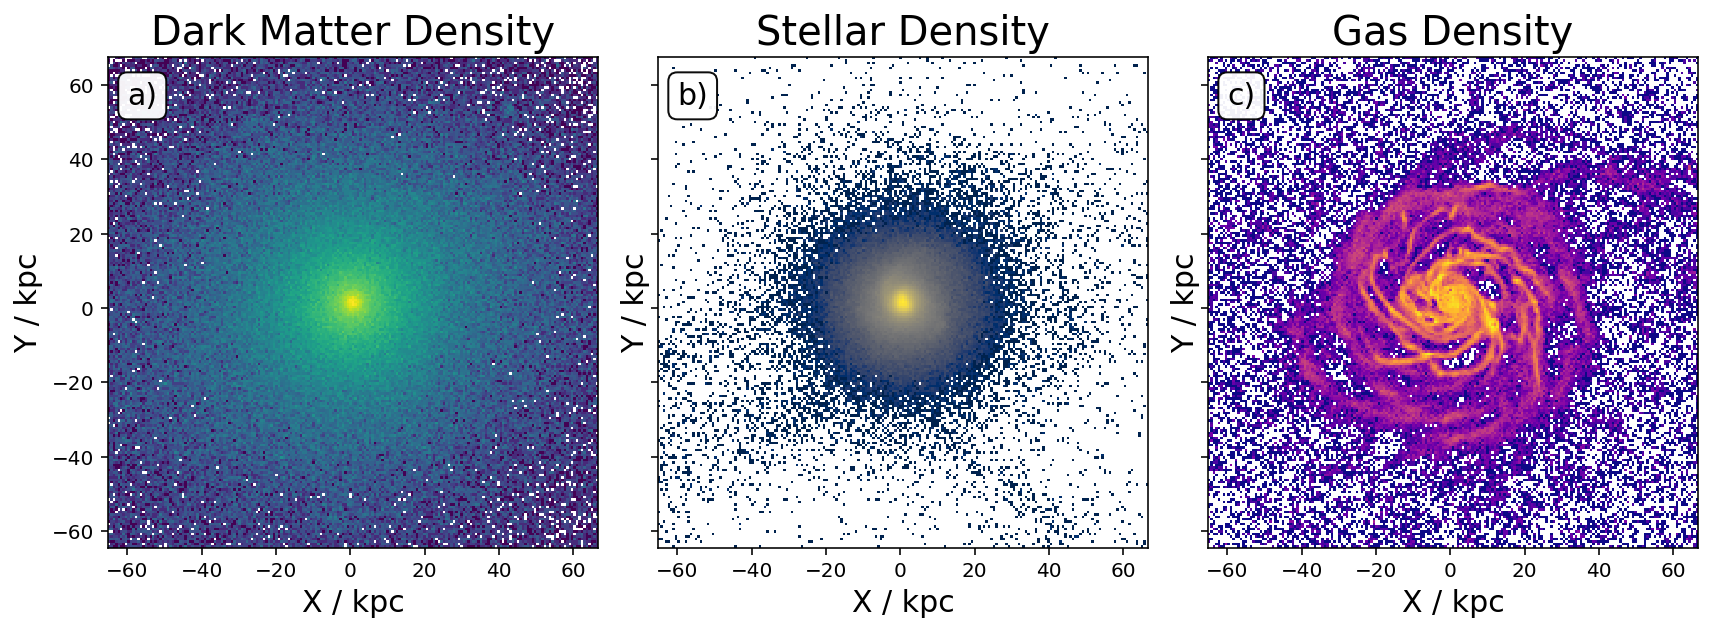

Saved as NIHAO_g8.26e11_pilot_darkmatter_stars_gas_xz_1re.png


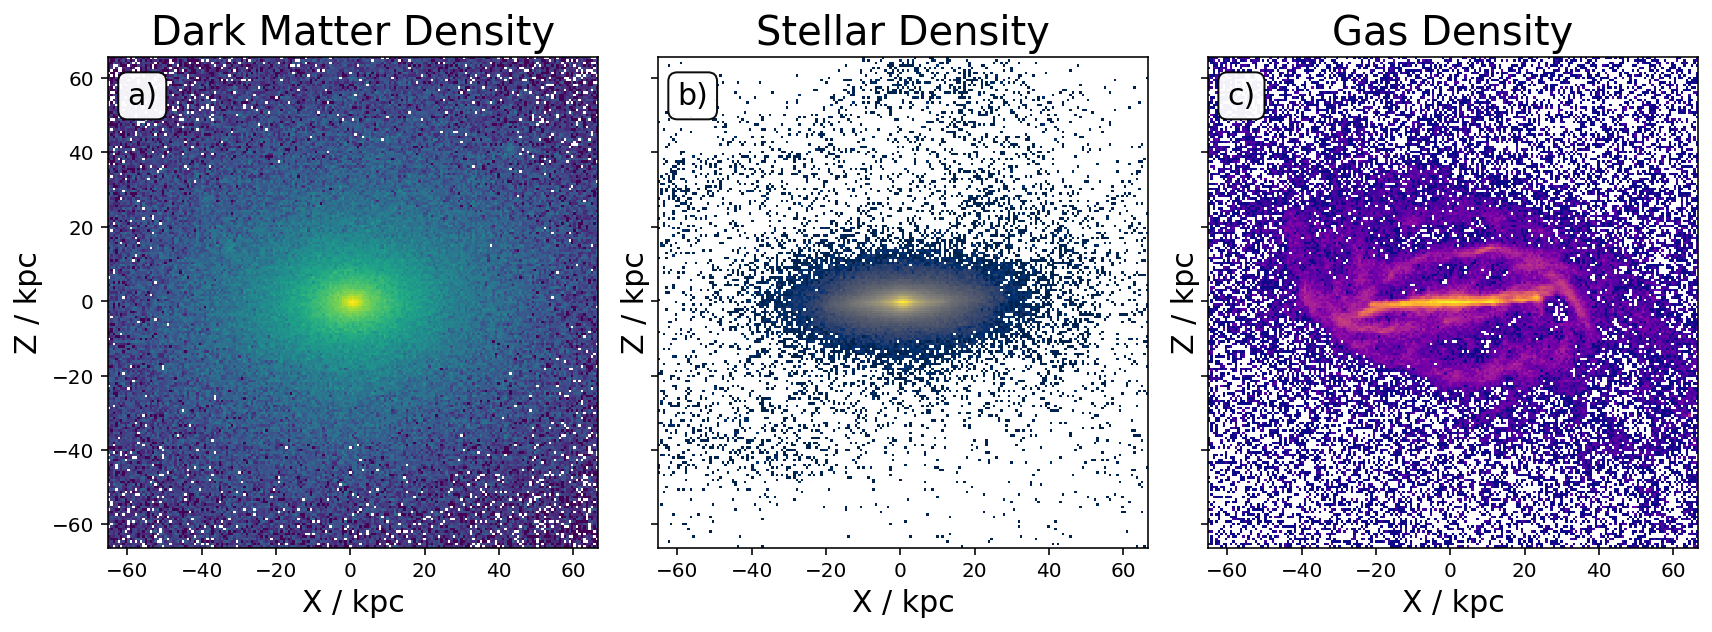

Saved as NIHAO_g8.26e11_pilot_darkmatter_stars_gas_yz_1re.png


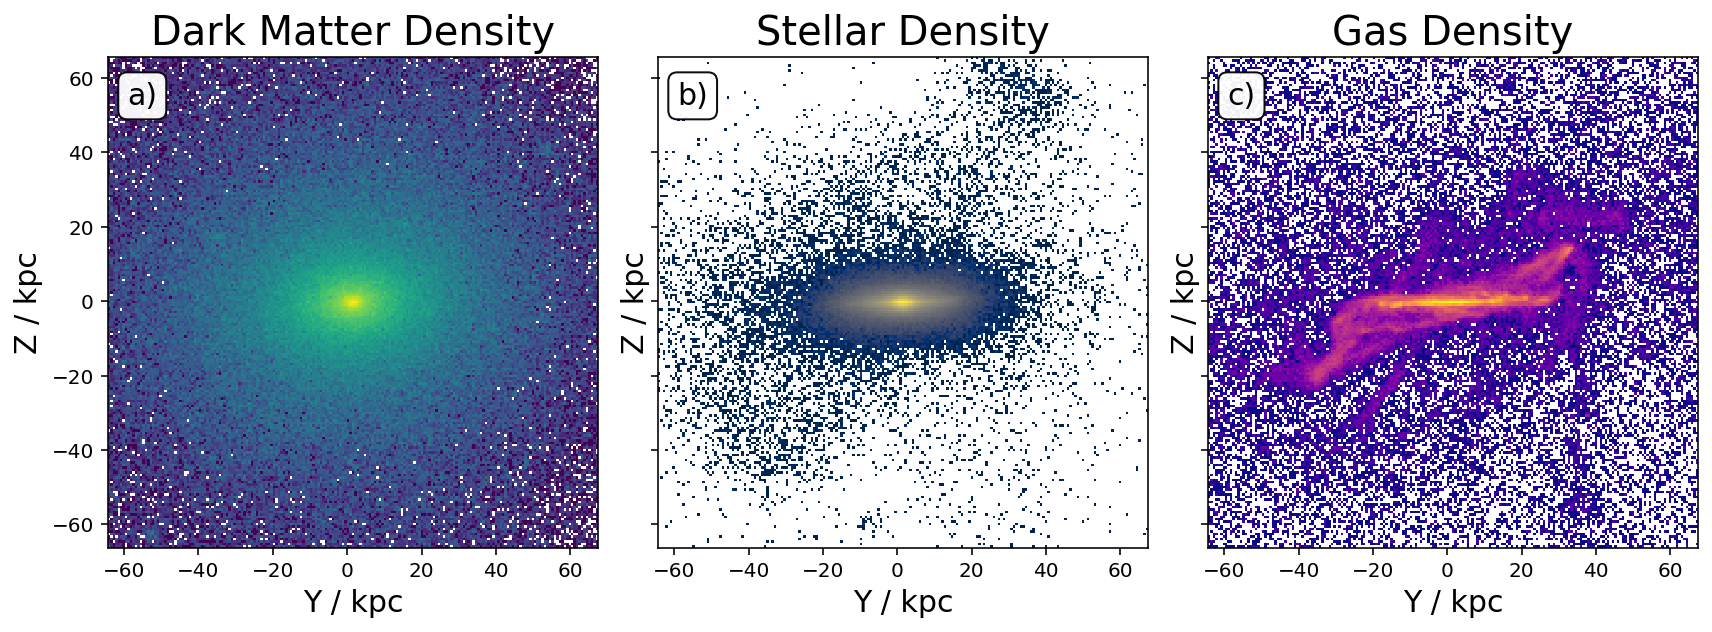

In [11]:
# Is the main halo now face on?
hist2d_darkmatter_stars_gas(main_halo, frame = 'xy', effective_radius=half_mass_radius, saveas=True)
hist2d_darkmatter_stars_gas(main_halo, frame = 'xz', effective_radius=half_mass_radius, saveas=True)
hist2d_darkmatter_stars_gas(main_halo, frame = 'yz', effective_radius=half_mass_radius, saveas=True)

# 3. Chemistry

Elemental abundances can be reported with 2 definitions.

In stellar spectroscopy, the definition via number densities (N_X) is more common:

```
   A(X) = log10(N_X / N_H) + 12
  [X/H] = A(X) - A(X_Sun)  
 [X/Fe] = [X/H] - [Fe/H]
```

In stellar evolution, the definition via mass fractions is more common:

```
    m_X = mass(X) / mass(total)  
m_H_Sun = 0.74
m_X_Sun = 10^(A(X) - 12) * u_mass(X) * m_H_Sun
```

To convert between mass fraction and number density, the following relationship can be used:
```
  [X/H] = log10(m_X / m_H) - log10(m_X_Sun / m_H_Sun)
```

In [12]:
# Abundances are reported in mass fractions.
# To convert to number densities, we need to convert via solar abundance x and atomic mass m.

# Atomic masses:
atomic_masses = {
    'H'  :   1.008, 'He' :   4.003, 'Li' :   6.941, 'Be' :   9.012,\
    'B'  :  10.811, 'C'  :  12.011, 'N'  :  14.007, 'O'  :  15.999,\
    'F'  :  18.998, 'Ne' :  20.180, 'Na' :  22.990, 'Mg' :  24.305,\
    'Al' :  26.982, 'Si' :  28.086, 'P'  :  30.974, 'S'  :  32.066,\
    'Cl' :  35.453, 'Ar' :  39.948, 'K'  :  39.098, 'Ca' :  40.078,\
    'Sc' :  44.956, 'Ti' :  47.867, 'V'  :  50.942, 'Cr' :  51.996,\
    'Mn' :  54.938, 'Fe' :  55.845, 'Co' :  58.933, 'Ni' :  58.693,\
    'Cu' :  63.546, 'Zn' :  65.380, 'Ga' :  69.723, 'Ge' :  72.631,\
    'As' :  74.922, 'Se' :  78.971, 'Br' :  79.904, 'Kr' :  84.798,\
    'Rb' :  84.468, 'Sr' :  87.620, 'Y'  :  88.906, 'Zr' :  91.224,\
    'Nb' :  92.906, 'Mo' :  95.950, 'Tc' :  98.907, 'Ru' : 101.070,\
    'Rh' : 102.906, 'Pd' : 106.420, 'Ag' : 107.868, 'Cd' : 112.414,\
    'In' : 114.818, 'Sn' : 118.711, 'Sb' : 121.760, 'Te' : 126.700,\
    'I'  : 126.904, 'Xe' : 131.294, 'Cs' : 132.905, 'Ba' : 137.328,\
    'La' : 138.905, 'Ce' : 140.116, 'Pr' : 140.908, 'Nd' : 144.243,\
    'Pm' : 144.913, 'Sm' : 150.360, 'Eu' : 151.964, 'Gd' : 157.250 \
}

# Solar abundances from Asplund+2009
solar_abund = {
    'H'  : 12.00, 'He' : 10.93, 'Li' : 1.05, 'Be' : 1.38, 'B'  : 2.70,
    'C'  : 8.43,  'N'  : 7.83,  'O'  : 8.69,  'F'  : 4.56, 'Ne' : 7.93,
    'Na' : 6.24,  'Mg' : 7.60,  'Al' : 6.45,  'Si' : 7.51, 'P'  : 5.41,
    'S'  : 7.12,  'Cl' : 5.50,  'Ar' : 6.40,  'K'  : 5.03, 'Ca' : 6.34,
    'Sc' : 3.15,  'Ti' : 4.95,  'V'  : 3.93,  'Cr' : 5.64, 'Mn' : 5.43,
    'Fe' : 7.50,  'Co' : 4.99,  'Ni' : 6.22,  'Cu' : 4.19, 'Zn' : 4.56,
    'Ga' : 3.04,  'Ge' : 3.65,  'As' : 2.30,  'Se' : 3.34, 'Br' : 2.54,
    'Kr' : 3.25,  'Rb' : 2.36,  'Sr' : 2.87,  'Y'  : 2.21, 'Zr' : 2.58,
    'Nb' : 1.46,  'Mo' : 1.88,  'Ru' : 1.75,  'Rh' : 0.91, 'Pd' : 1.57,
    'Ag' : 0.94,  'Cd' : 1.71,  'In' : 0.80,  'Sn' : 2.04, 'Sb' : 1.01,
    'Te' : 2.18,  'I'  : 1.55,  'Xe' : 2.24,  'Cs' : 1.08, 'Ba' : 2.18,
    'La' : 1.10,  'Ce' : 1.58,  'Pr' : 0.72,  'Nd' : 1.42, 'Sm' : 0.96,
    'Eu' : 0.52,  'Gd' : 1.07
}

element_mass_to_density = dict()

for element in solar_abund.keys():
    if element == 'H':
        element_mass_to_density['H'] = 0.74
    else:
        element_mass_to_density[element] = 10**(solar_abund[element]-12.0) * atomic_masses[element] * element_mass_to_density['H']

In [13]:
# Create the function to convert elemental mass fractions to [X/H] elemental abundances with "element" as argument
@TipsySnap.derived_quantity
def X_H(self, element, minimum_X_H = -10.0):
    
    MassFrac_available = glob.glob('NIHAO_raw/'+simulation_name+'/'+simulation_mass+'.'+simulation_snapshot+'.'+element+'MassFrac*')
    
    # Assume abundances for element X are saved under a total XMassFrac, and report dummy arrays for SNII, SNIA, and AGB
    if len(MassFrac_available) == 1:
        # Correct MassFrac that are wrongly reported as 0.0 to the minimum mass fraction
        min_MassFrac = np.amin(self[element+'MassFrac'][np.where(self[element+'MassFrac'] > 0)])
        self[element+'MassFrac'][np.where(self[element+'MassFrac'] == 0)] = min_MassFrac
        
        return (
            (np.log10((self[element+'MassFrac']) / self['hydrogen']) - np.log10(element_mass_to_density[element] / element_mass_to_density['H'])).clip(min=minimum_X_H),
            [np.nan],
            [np.nan],
            [np.nan]
        )
    
    # For more than 1 MassFrac per element, combine SNII, SNIA, and AGB contributions
    else:
        
        # Correct MassFrac that are wrongly reported as 0.0 to the minimum mass fraction
        for channel in ['SNII','SNIA','AGB']:
            try:
                min_MassFrac = np.amin(self[element+'MassFrac_'+channel][np.where(self[element+'MassFrac_'+channel] > 0)])
            except:
                min_MassFrac = 10**(-45)
            self[element+'MassFrac_'+channel][np.where(self[element+'MassFrac_'+channel] == 0)] = min_MassFrac

        return (
            (np.log10((self[element+'MassFrac_SNII'] + self[element+'MassFrac_SNIA'] + self[element+'MassFrac_AGB']) / self['hydrogen']) - np.log10(element_mass_to_density[element] / element_mass_to_density['H'])).clip(min=minimum_X_H),
            (np.log10((self[element+'MassFrac_SNII']) / self['hydrogen']) - np.log10(element_mass_to_density[element] / element_mass_to_density['H'])).clip(min=minimum_X_H),
            (np.log10((self[element+'MassFrac_SNIA']) / self['hydrogen']) - np.log10(element_mass_to_density[element] / element_mass_to_density['H'])).clip(min=minimum_X_H),
            (np.log10((self[element+'MassFrac_AGB' ]) / self['hydrogen']) - np.log10(element_mass_to_density[element] / element_mass_to_density['H'])).clip(min=minimum_X_H),
        )

In [14]:
print('Looping through elements H, He, Li, ... Eu, Gd to identify elements in simulation')
elements_in_simulation = []

for element in solar_abund.keys():
    if element != 'H':
        try:
            main_halo.s[element+'_H'], SNII, SNIa, AGB = X_H(main_halo.s, element)
            print('['+element+'/H] converted')
            # By default, SNII/SNIa/AGB etc. are dummy NaN arrays.
            # But if the first entry is finite, then there are actually individual abundances reported!
            if np.isfinite(SNII[0]):
                main_halo.s[element+'_H_SNII'] = SNII
                main_halo.s[element+'_H_SNIa'] = SNIa
                main_halo.s[element+'_H_AGB']  = AGB

            # For Section 5 below, we also compute [Fe/H] for the full simulation, to see what we are missing out on, 
            # when limiting ourselves to the main halo.
            if element == 'Fe':
                simulation_full.s[element+'_H'], SNII, SNIa, AGB = X_H(simulation_full.s, element)
                if np.isfinite(SNII[0]):
                    simulation_full.s[element+'_H_SNII'] = SNII
                    simulation_full.s[element+'_H_SNIa'] = SNIa
                    simulation_full.s[element+'_H_AGB']  = AGB

            elements_in_simulation.append(element)
            
        except:
            pass

print('Elements in simulation: ',elements_in_simulation)

Looping through elements H, He, Li, ... Eu, Gd to identify elements in simulation
[He/H] converted
[C/H] converted
[N/H] converted
[O/H] converted
[Ne/H] converted
[Mg/H] converted
[Al/H] converted
[Si/H] converted
[P/H] converted
[S/H] converted
[V/H] converted
[Cr/H] converted
[Mn/H] converted
[Fe/H] converted
[Co/H] converted
[Ba/H] converted
Elements in simulation:  ['He', 'C', 'N', 'O', 'Ne', 'Mg', 'Al', 'Si', 'P', 'S', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ba']


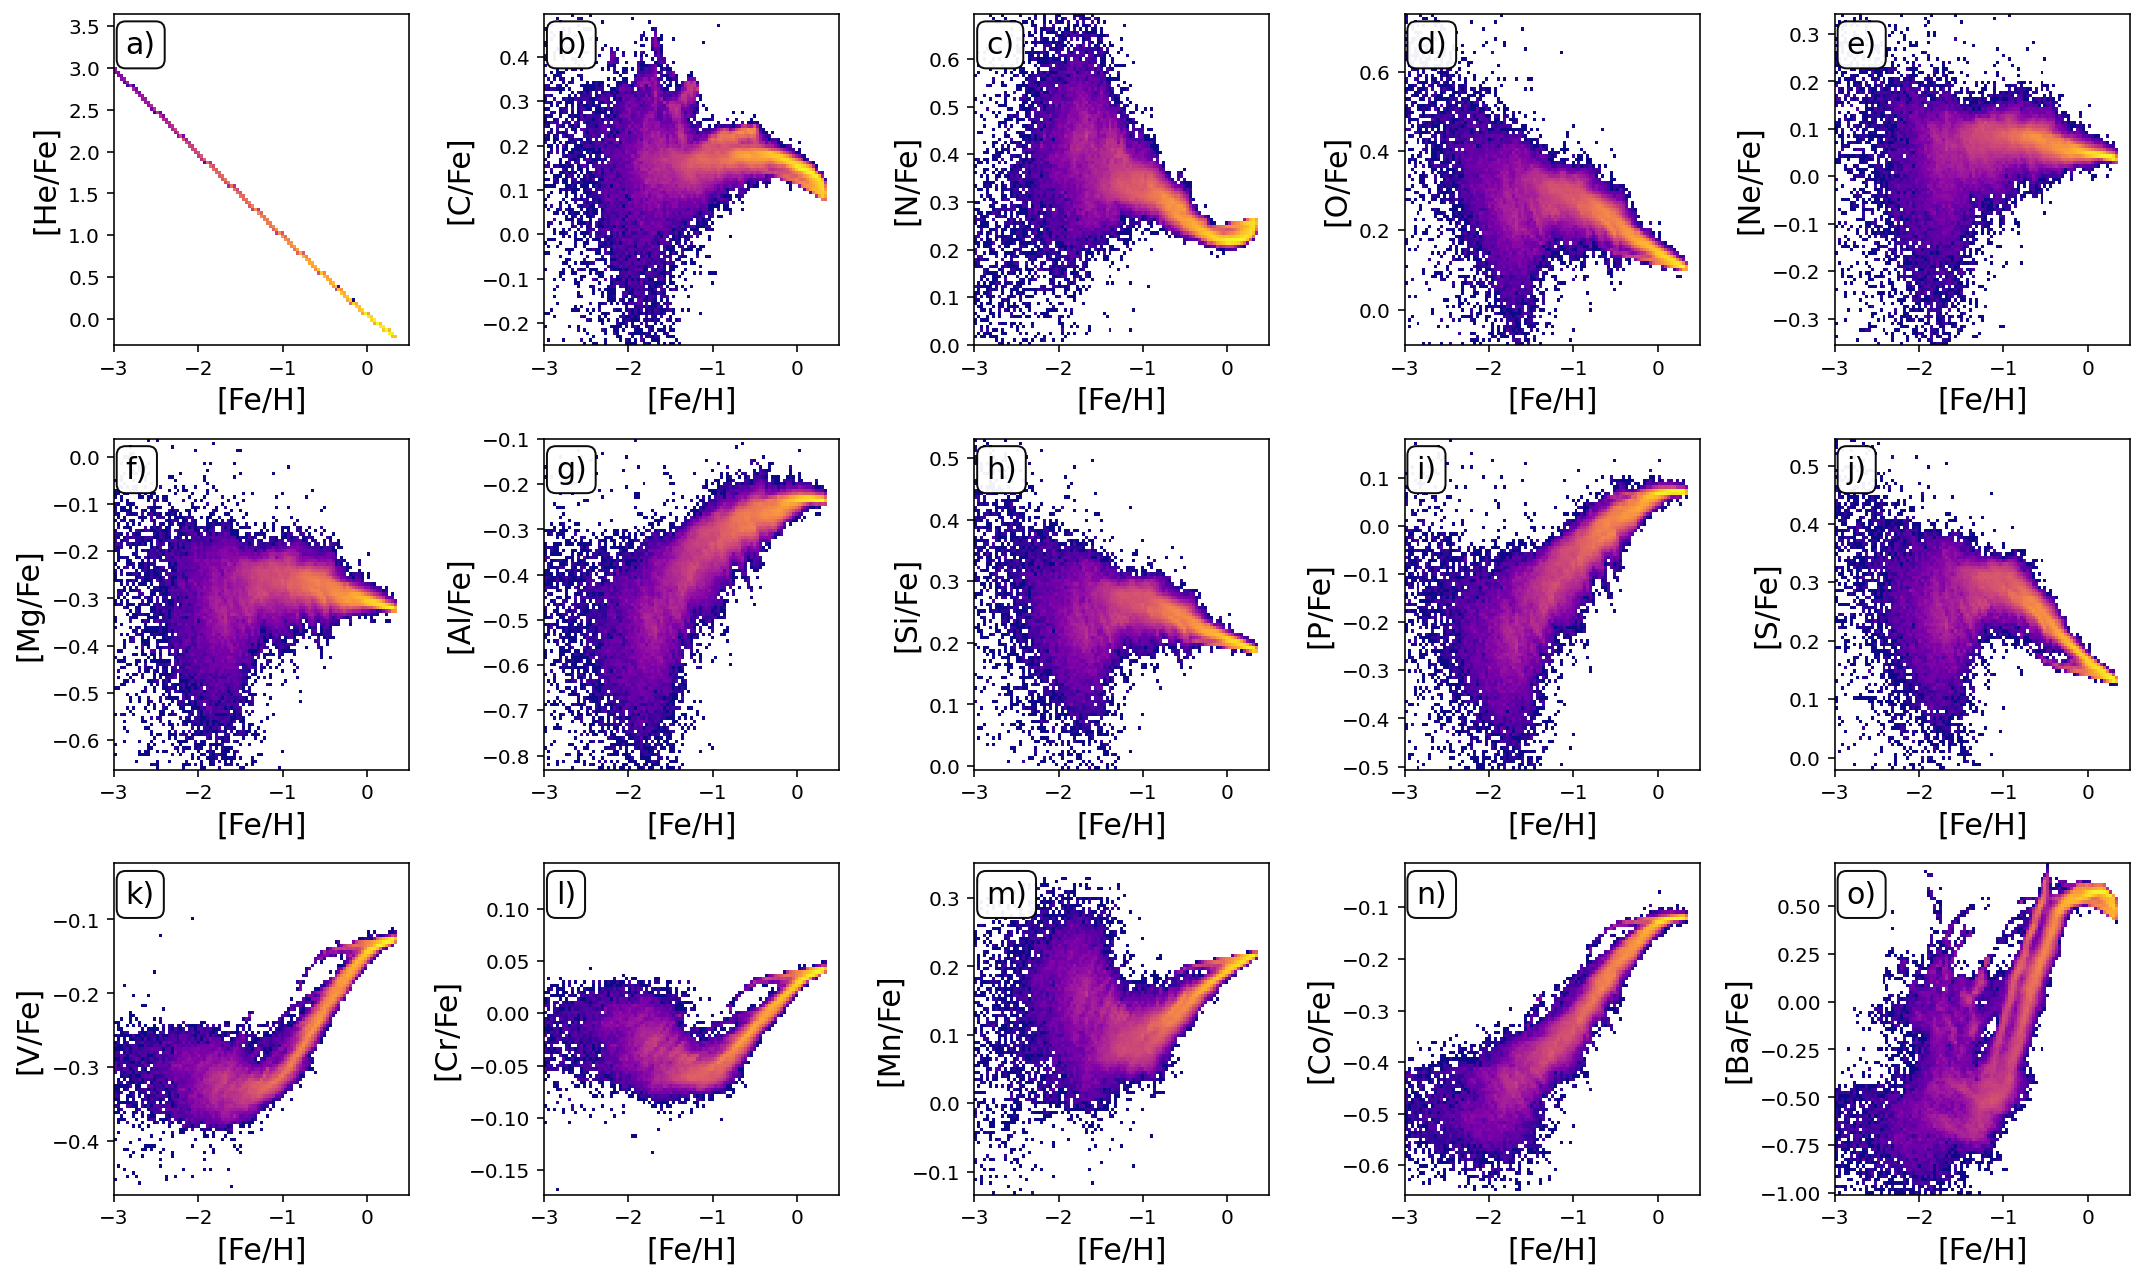

In [15]:
def optimal_grid(num_elements):
    # Find the optimal grid size (rows, cols) for num_elements
    rows = int(np.floor(np.sqrt(num_elements)))
    cols = int(np.ceil(num_elements / rows))
    if rows * cols < num_elements:
        rows += 1
    return rows, cols

def plot_fe_h_vs_x_fe(saveas=False):
    
    elements_in_simulation_without_fe = elements_in_simulation.copy()
    elements_in_simulation_without_fe.remove('Fe')
    
    rows, cols = optimal_grid(len(elements_in_simulation_without_fe))
    
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols,3*rows))
    axes = axes.flatten()
    
    for i, element in enumerate(elements_in_simulation_without_fe):
        ax = axes[i]
        ax.text(0.04,0.95,panels[i],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        ax.set_xlabel('[Fe/H]')
        ax.set_ylabel('['+element+'/Fe]')

        minmax = np.percentile(main_halo.s[element+'_H'] - main_halo.s['Fe_H'], q = [0.1,99.9])
        ax.hist2d(
            main_halo.s['Fe_H'],
            main_halo.s[element+'_H'] - main_halo.s['Fe_H'],
            bins = (np.linspace(-3,0.5,100),np.linspace(minmax[0]-0.1,minmax[1]+0.1,100)),
            cmin = 1, cmap = 'plasma',
            norm = LogNorm()
        )
    
    # Turn off empty subpanels
    for j in range(len(elements_in_simulation), rows * cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    
    if saveas:
        filename = 'NIHAO_'+simulation_name+'_feh_xfe_overview.png'
        directory = 'NIHAO_prepared/NIHAO_'+simulation_name+'_diagnostic_plots/'
        Path(directory).mkdir(parents=True, exist_ok=True)
        plt.savefig(directory+filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
plot_fe_h_vs_x_fe(saveas=True)

In [16]:
def plot_channel_contributions(element, ymin = -6.0, ymax = 1.0, bins = 200, saveas=False):
    f, gs = plt.subplots(1,4,figsize=(12,2.5))
    ax = gs[0]
    ax.text(0.04,0.95,panels[0],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('[Fe/H]',fontsize=15)
    ax.set_ylabel(r'$N_\mathrm{['+element+'/H]}$',fontsize=15)
    ax.set_title('SNII Contribution',fontsize=12)

    ax.hist2d(
        main_halo.s['Fe_H'],
        10**main_halo.s[element+'_H'],
        bins = (np.linspace(-3,0.5,bins),10**np.linspace(ymin, ymax, bins)), cmin = 1, norm=LogNorm(),
        cmap = 'Greys'
    )

    ax.hist2d(
        main_halo.s['Fe_H'],
        10**main_halo.s[element+'_H_SNII'],
        bins = (np.linspace(-3,0.5,bins),10**np.linspace(ymin, ymax, bins)), cmin = 1, norm=LogNorm(),
        cmap = 'Blues'
    )
    ax.set_yscale('log')

    ax = gs[1]
    ax.text(0.04,0.95,panels[1],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('[Fe/H]',fontsize=15)
    ax.set_ylabel(r'$N_\mathrm{['+element+'/H]}$',fontsize=15)
    ax.set_title('SNIa Contribution',fontsize=12)

    ax.hist2d(
        main_halo.s['Fe_H'],
        10**main_halo.s[element+'_H'],
        bins = (np.linspace(-3,0.5,bins),10**np.linspace(ymin, ymax, bins)), cmin = 1, norm=LogNorm(),
        cmap = 'Greys'
    )
    ax.hist2d(
        main_halo.s['Fe_H'],
        10**main_halo.s[element+'_H_SNIa'],
        bins = (np.linspace(-3,0.5,bins),10**np.linspace(ymin, ymax, bins)), cmin = 1, norm=LogNorm(),
        cmap = 'Reds'
    )
    ax.set_yscale('log')

    ax = gs[2]
    ax.text(0.04,0.95,panels[2],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('[Fe/H]',fontsize=15)
    ax.set_ylabel(r'$N_\mathrm{['+element+'/H]}$',fontsize=15)
    ax.set_title('AGB Contribution',fontsize=12)

    ax.hist2d(
        main_halo.s['Fe_H'],
        10**main_halo.s[element+'_H'],
        bins = (np.linspace(-3,0.5,bins),10**np.linspace(ymin, ymax, bins)), cmin = 1, norm=LogNorm(),
        cmap = 'Greys'
    )
    ax.hist2d(
        main_halo.s['Fe_H'],
        10**main_halo.s[element+'_H_AGB'],
        bins = (np.linspace(-3,0.5,bins),10**np.linspace(ymin, ymax, bins)), cmin = 1, norm=LogNorm(),
        cmap = 'Greens'
    );
    ax.set_yscale('log')
    
    ax = gs[3]
    ax.text(0.04,0.95,panels[3],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('[Fe/H]',fontsize=15)
    ax.set_ylabel(r'$N_\mathrm{Channel} / N_\mathrm{Total}$',fontsize=15)
    ax.set_title('Relative Contribution',fontsize=12)

    for colormap, channel in zip(['Blues','Reds','Greens'],['SNII','SNIa','AGB']):
        ax.hist2d(
            main_halo.s['Fe_H'],
            (10**main_halo.s[element+'_H_'+channel]) / (10**main_halo.s[element+'_H']),
            bins = (np.linspace(-3,0.5,bins),np.linspace(0,1, bins)), cmin = 1, norm=LogNorm(),
            cmap = colormap
        );
    plt.tight_layout()
    
    if saveas:
        filename = 'NIHAO_'+simulation_name+'_nucleosynthesis_channels_'+element+'_H.png'
        directory = 'NIHAO_prepared/NIHAO_'+simulation_name+'_diagnostic_plots/'
        Path(directory).mkdir(parents=True, exist_ok=True)
        plt.savefig(directory+filename, dpi=300, bbox_inches='tight')
        print('Saved as '+filename)
    plt.show()
    plt.close()

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_He_H.png


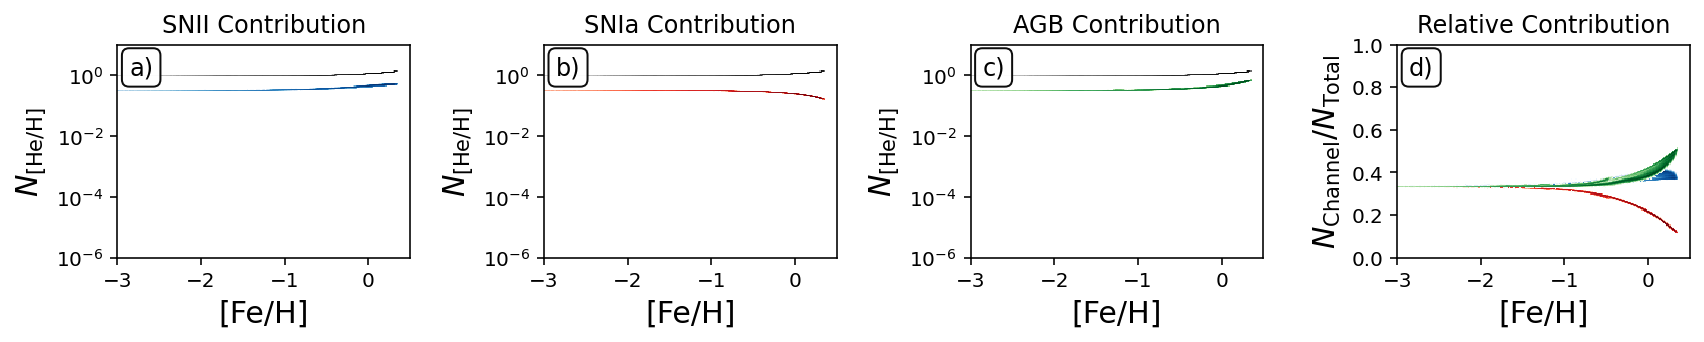

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_C_H.png


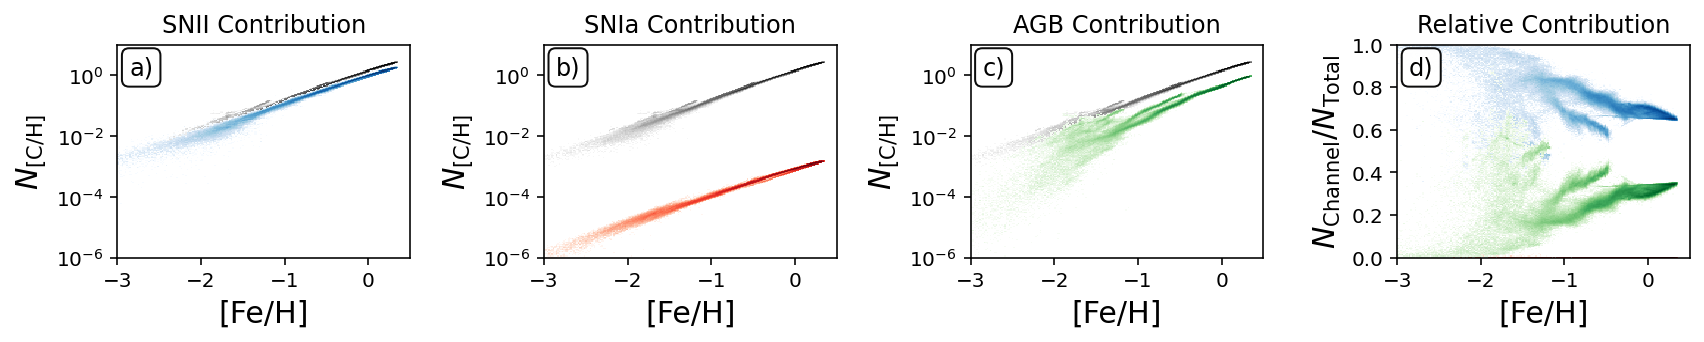

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_N_H.png


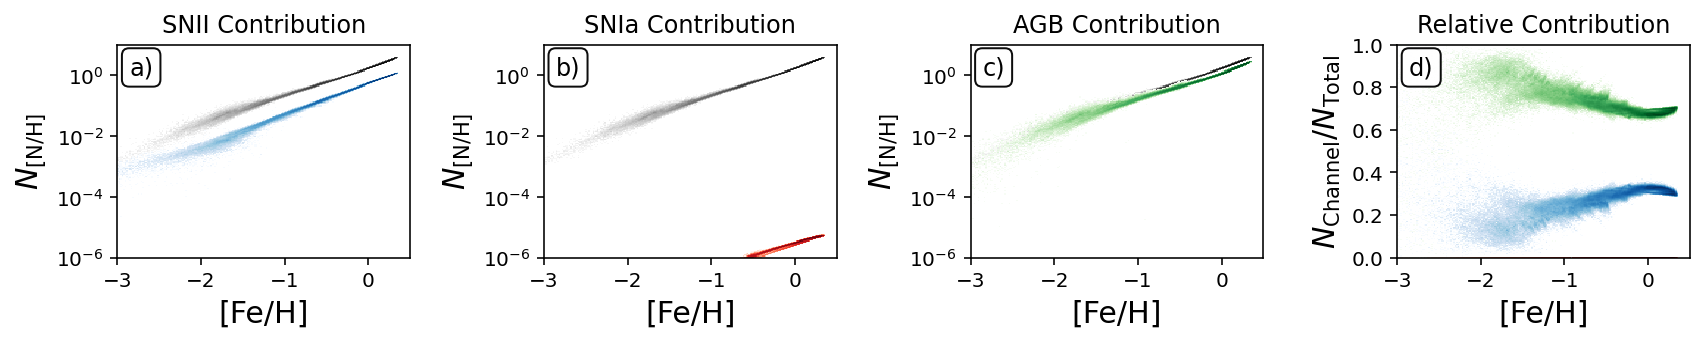

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_O_H.png


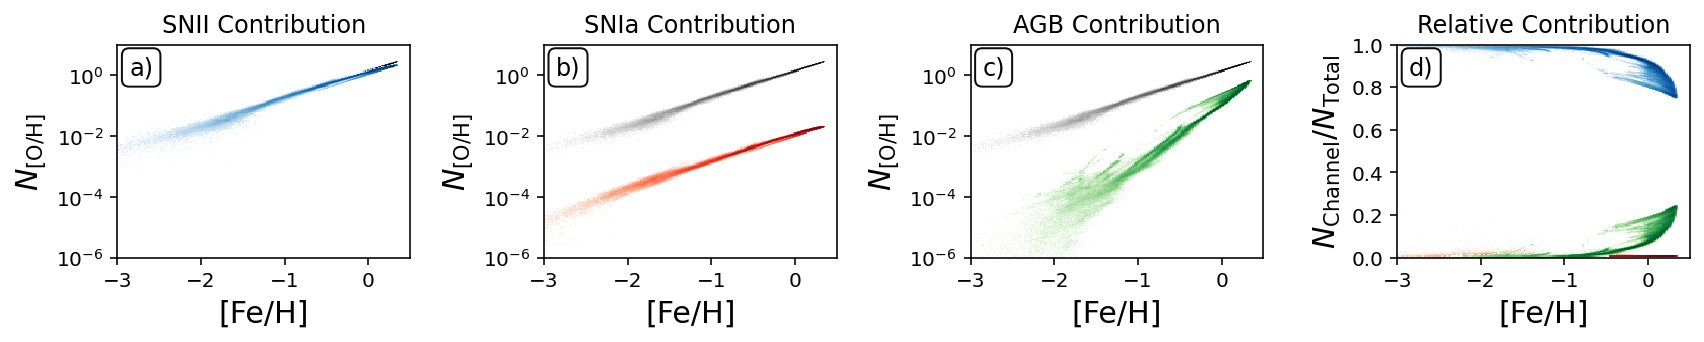

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Ne_H.png


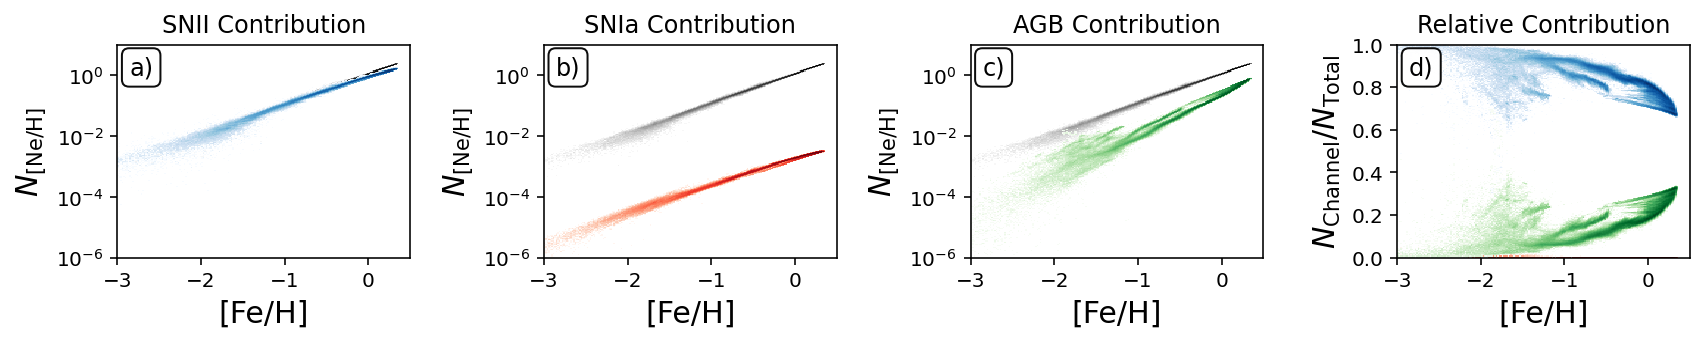

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Mg_H.png


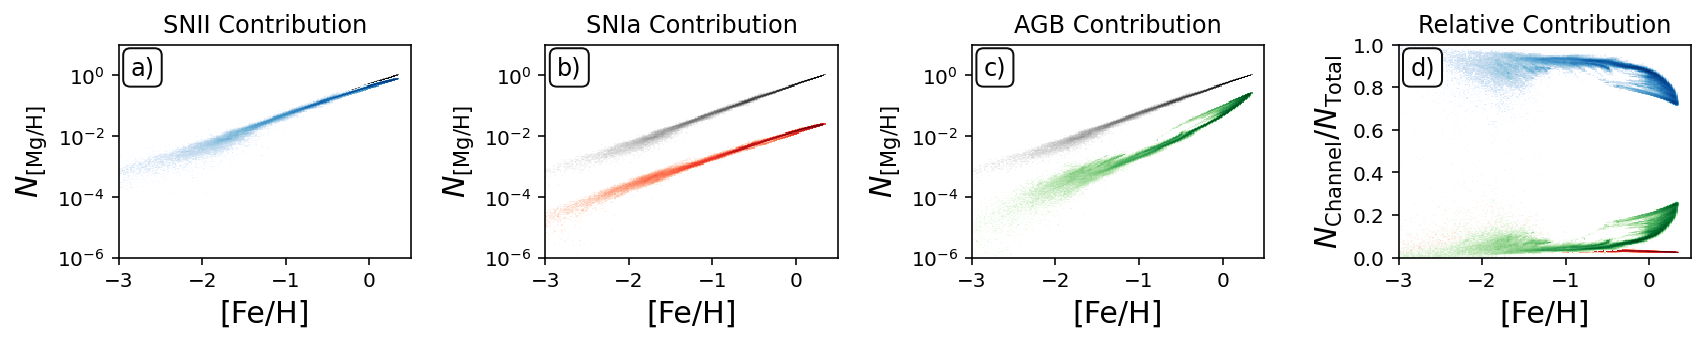

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Al_H.png


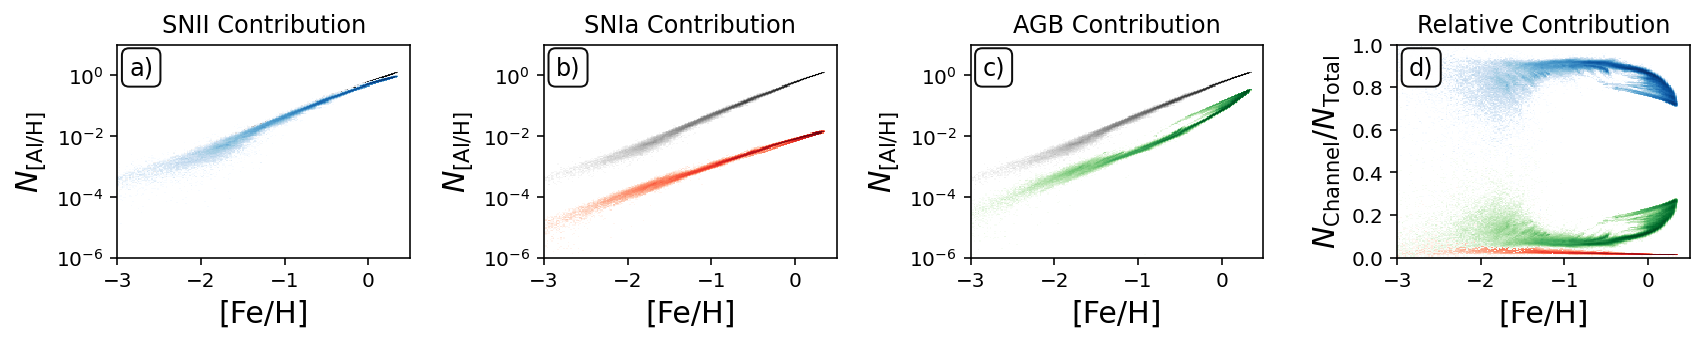

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Si_H.png


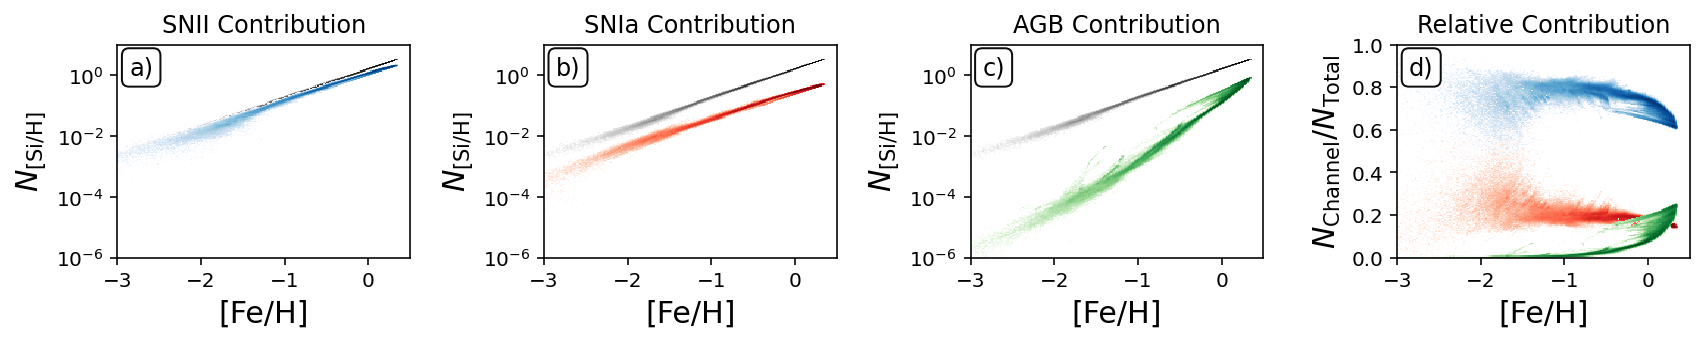

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_P_H.png


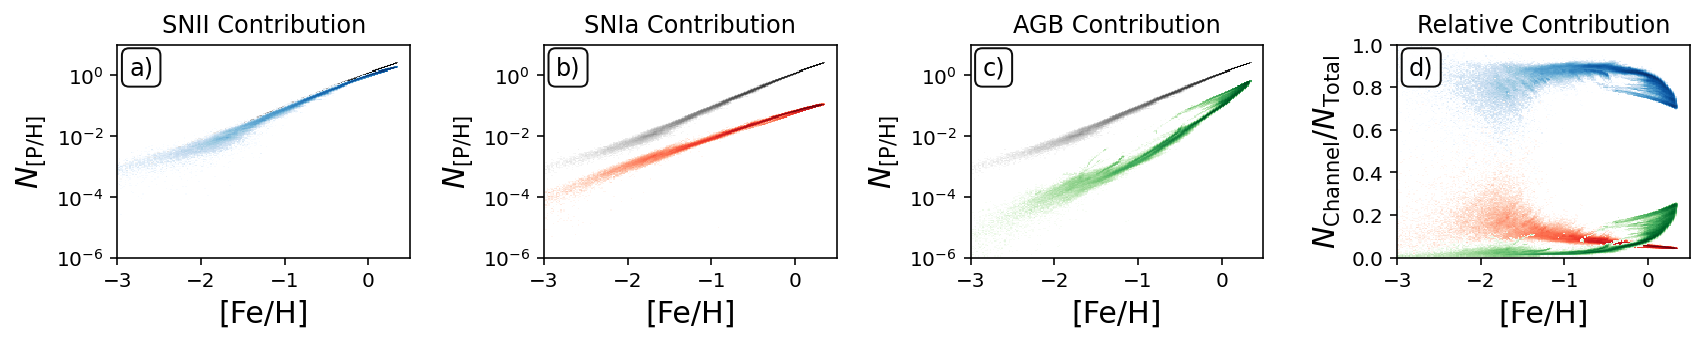

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_S_H.png


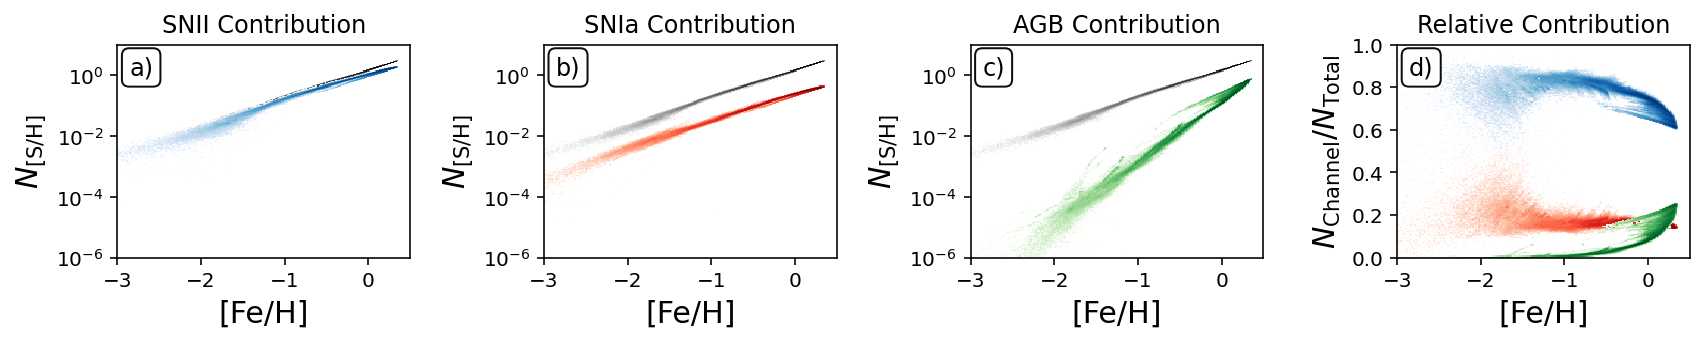

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_V_H.png


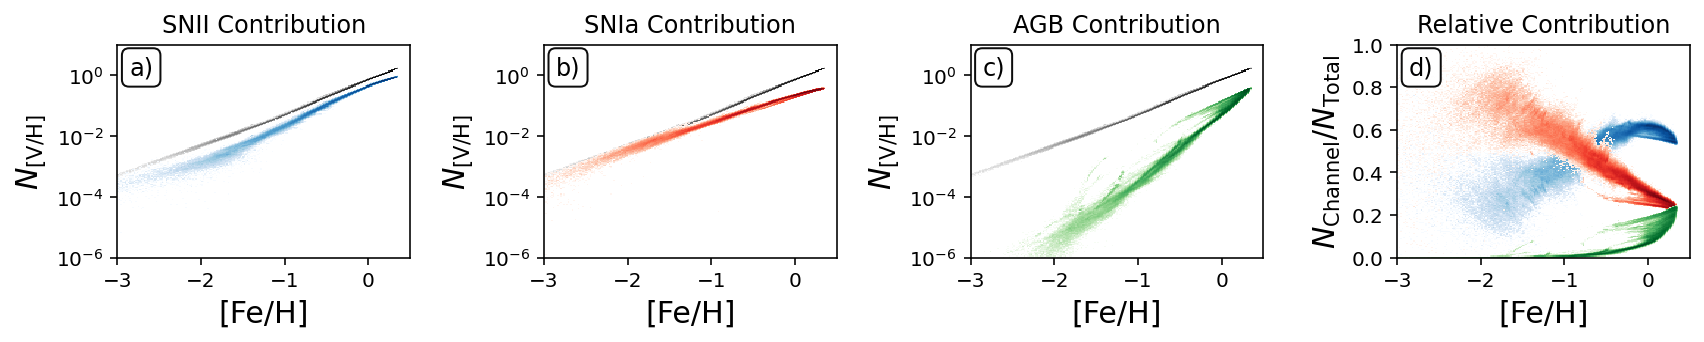

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Cr_H.png


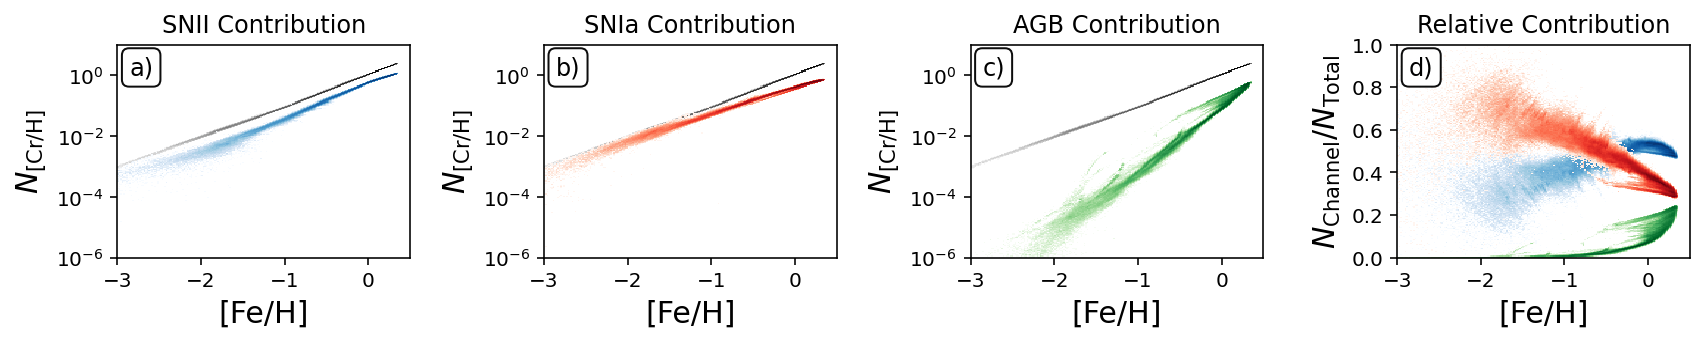

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Mn_H.png


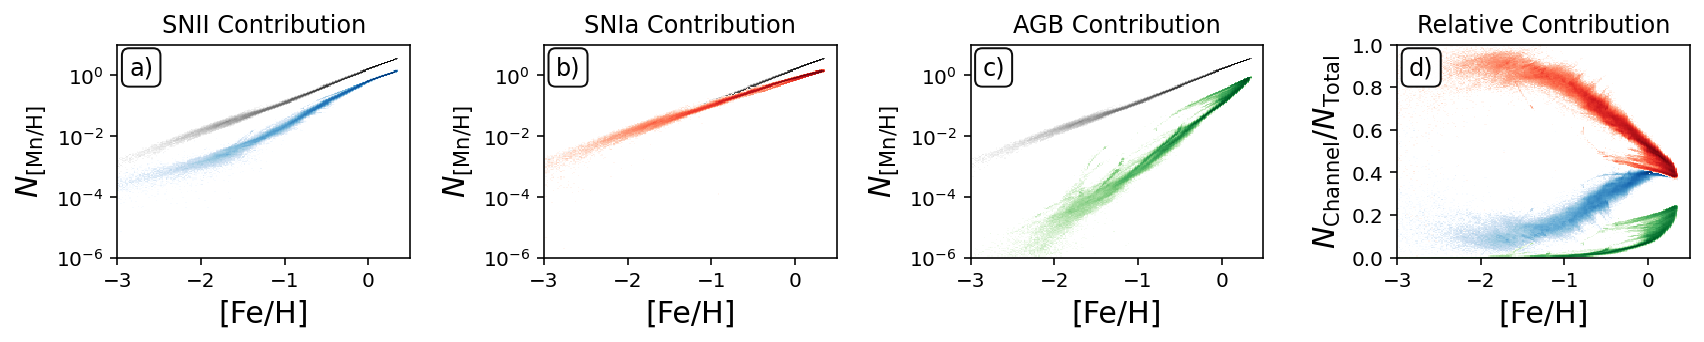

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Fe_H.png


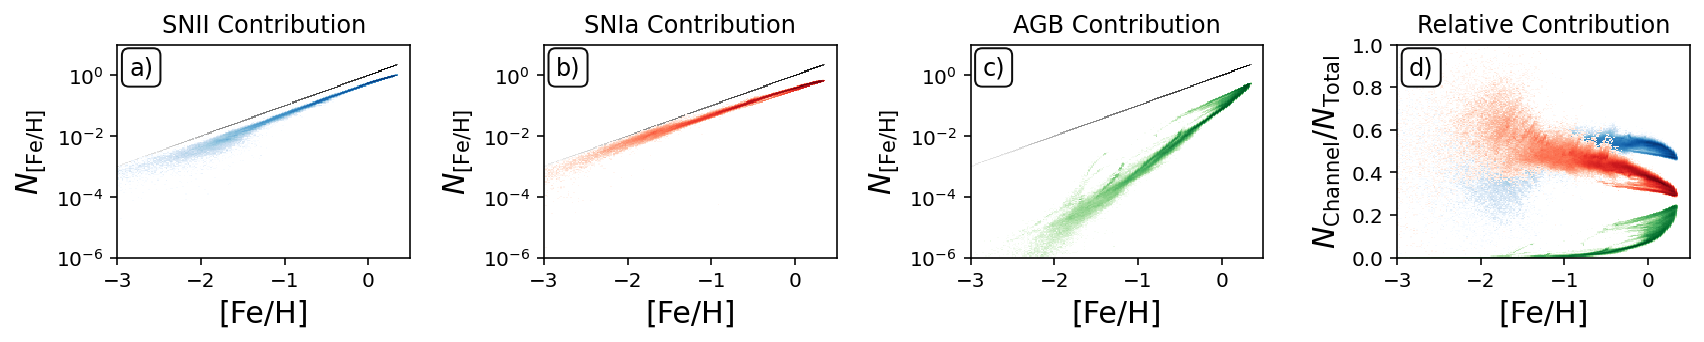

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Co_H.png


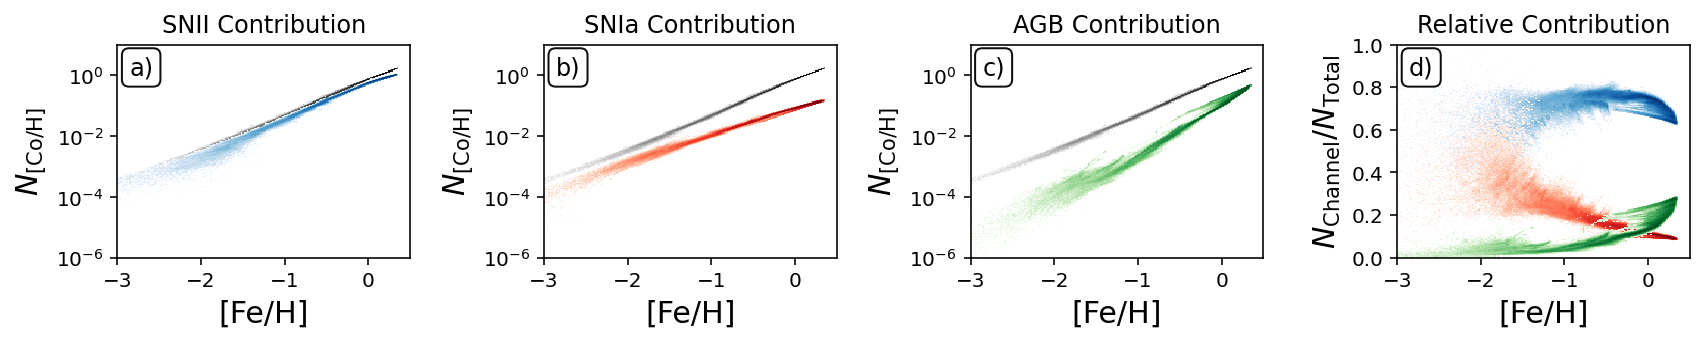

Saved as NIHAO_g8.26e11_pilot_nucleosynthesis_channels_Ba_H.png


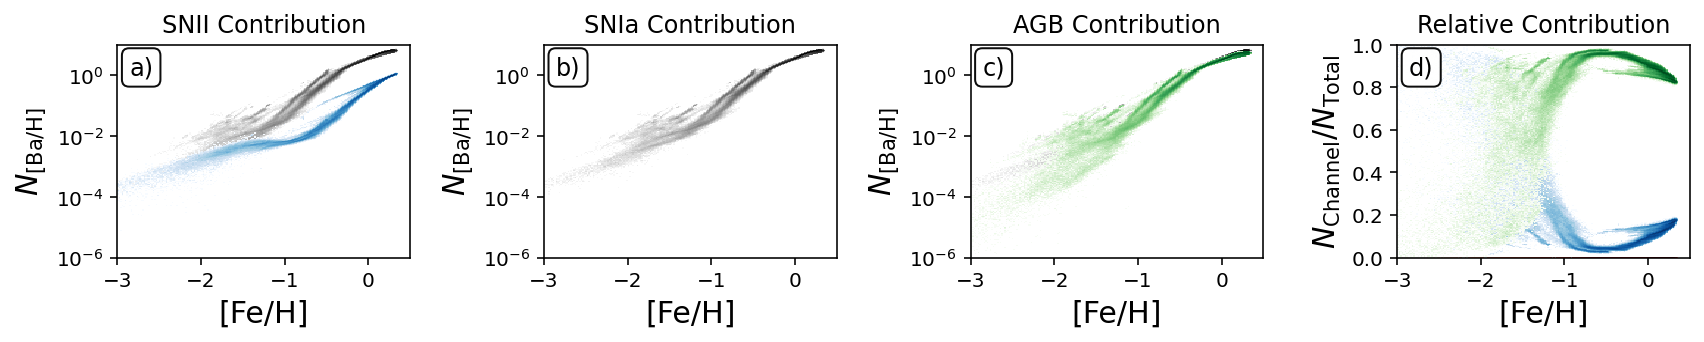

In [17]:
for element in elements_in_simulation:
    if element+'_H_AGB' in main_halo.s.keys():
        plot_channel_contributions(element,saveas=True)

# 4. Save all relevant information in a FITS Table with physical units

## 4.1 Dark Matter information

In [18]:
simulation_lite_dm = Table()

for pos in ['x','y','z']:
    simulation_lite_dm[pos] = np.array(main_halo.dm[pos].in_units('kpc'),dtype=np.float32)
    simulation_lite_dm['v'+pos] = np.array(main_halo.dm['v'+pos].in_units('km s**-1'),dtype=np.float32)

simulation_lite_dm['potential_phi'] = np.array(main_halo.dm['phi'].in_units('km**2 s**-2'),dtype=np.float32)
simulation_lite_dm['mass'] = np.array(main_halo.dm['mass'].in_units('Msol'),dtype=np.float32)

In [19]:
Path('NIHAO_prepared/').mkdir(parents=True, exist_ok=True)
simulation_lite_dm.write('NIHAO_prepared/NIHAO_'+simulation_name+'_darkmatter.fits',overwrite=True)

## 4.2 Star information

In [20]:
simulation_lite_stars = Table()

for pos in ['x','y','z']:
    simulation_lite_stars[pos] = np.array(main_halo.s[pos].in_units('kpc'),dtype=np.float32)
    simulation_lite_stars['v'+pos] = np.array(main_halo.s['v'+pos].in_units('km s**-1'),dtype=np.float32)

simulation_lite_stars['potential_phi'] = np.array(main_halo.s['phi'].in_units('km**2 s**-2'),dtype=np.float32)
simulation_lite_stars['mass'] = np.array(main_halo.s['mass'].in_units('Msol'),dtype=np.float32)
simulation_lite_stars['age'] = np.array(main_halo.s['age'].in_units('Gyr'),dtype=np.float32)

simulation_lite_stars['metallicity_z'] = np.array(main_halo.s['metals'],dtype=np.float32)

for element in solar_abund.keys():
    if element+'_H' in main_halo.s.keys():
        simulation_lite_stars[element+'_H'] = np.array(main_halo.s[element+'_H'],dtype=np.float32)
    for channel in ['SNII','SNIa','AGB']:
        if element+'_H_'+channel in main_halo.s.keys():
            simulation_lite_stars[element+'_H_'+channel] = np.array(main_halo.s[element+'_H_'+channel],dtype=np.float32)

In [21]:
Path('NIHAO_prepared/').mkdir(parents=True, exist_ok=True)
simulation_lite_stars.write('NIHAO_prepared/NIHAO_'+simulation_name+'_stars.fits',overwrite=True)

## 4.3 Gas information

In [22]:
simulation_lite_gas = Table()

for pos in ['x','y','z']:
    simulation_lite_gas[pos] = np.array(main_halo.gas[pos].in_units('kpc'),dtype=np.float32)
    simulation_lite_gas['v'+pos] = np.array(main_halo.gas['v'+pos].in_units('km s**-1'),dtype=np.float32)

simulation_lite_gas['potential_phi'] = np.array(main_halo.gas['phi'].in_units('km**2 s**-2'),dtype=np.float32)
simulation_lite_gas['mass'] = np.array(main_halo.gas['mass'].in_units('Msol'),dtype=np.float32)
simulation_lite_gas['temperature'] = np.array(main_halo.gas['temp'].in_units('K'),dtype=np.float32)
simulation_lite_gas['density_rho'] = np.array(main_halo.gas['rho'].in_units('Msol kpc**-3'),dtype=np.float32)

simulation_lite_gas['metallicity_z'] = np.array(main_halo.gas['metals'],dtype=np.float32)

In [23]:
Path('NIHAO_prepared/').mkdir(parents=True, exist_ok=True)
simulation_lite_gas.write('NIHAO_prepared/NIHAO_'+simulation_name+'_gas.fits',overwrite=True)

# 5. Age/Redshift-Metallicity-Relation (full simulation vs. main halo)

Saved as NIHAO_g8.26e11_pilot_age_metallicity_relation.png


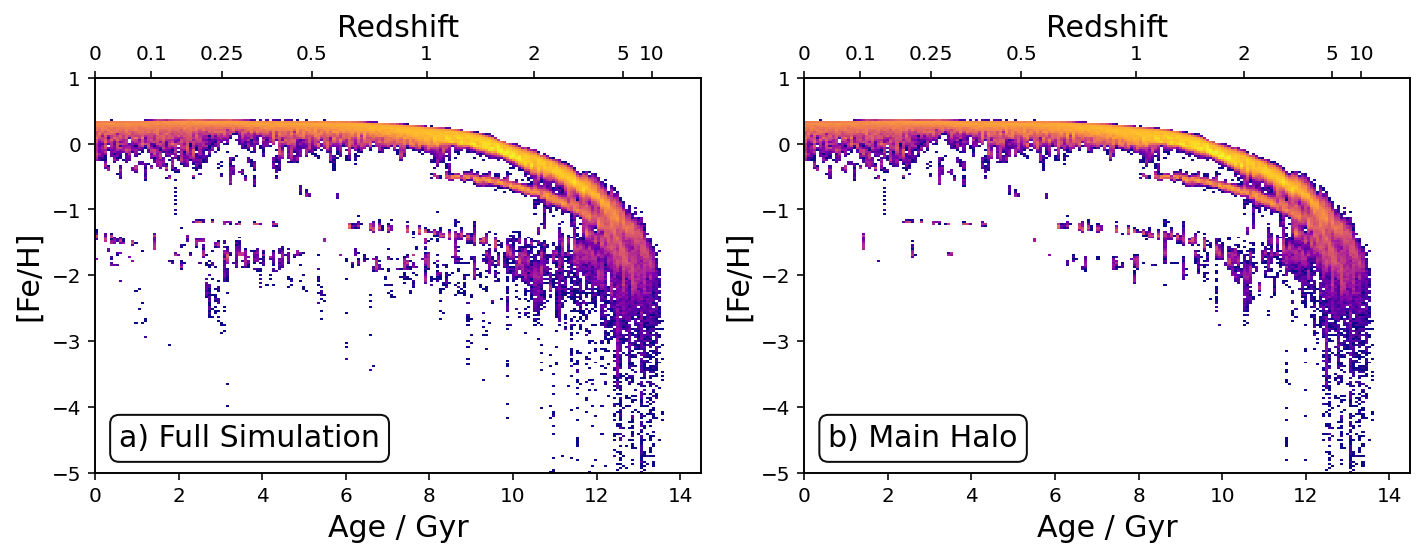

In [24]:
def plot_age_metallicity_relation(saveas=False):

    f, gs = plt.subplots(1,2,figsize=(10,4))#,sharex=True,sharey=True)

    ax = gs[0]
    ax.text(0.04,0.05,panels[0]+' Full Simulation',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.hist2d(
        simulation_full.s['age'].in_units('Gyr'),
        simulation_full.s['Fe_H'],
        bins = (np.linspace(0,14.5,200),np.linspace(-5.0,1.0,200)),
        cmin = 1, norm = LogNorm(),
        cmap = 'plasma'
    )

    # Create the secondary x-axis (redshift)
    ax2 = ax.twiny()
    # Set the redshift labels and ticks
    redshift_ticks = [0,0.1,0.25,0.5,1,2,5,10]  # Redshift ticks as integers
    age_ticks = [cosmo.age(0).value-cosmo.age(z).value for z in redshift_ticks]
    ax2.set_xticks(age_ticks)
    ax2.set_xticklabels(redshift_ticks)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel('Redshift')

    ax = gs[1]
    ax.text(0.04,0.05,panels[1]+' Main Halo',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.hist2d(
        simulation_lite_stars['age'],
        simulation_lite_stars['Fe_H'],
        bins = (np.linspace(0,14.5,200),np.linspace(-5.0,1.0,200)),
        cmin = 1, norm = LogNorm(),
        cmap = 'plasma'
    )

    # Create the secondary x-axis (redshift)
    ax2 = ax.twiny()
    # Set the redshift labels and ticks
    redshift_ticks = [0,0.1,0.25,0.5,1,2,5,10]  # Redshift ticks as integers
    age_ticks = [cosmo.age(0).value-cosmo.age(z).value for z in redshift_ticks]
    ax2.set_xticks(age_ticks)
    ax2.set_xticklabels(redshift_ticks)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel('Redshift')

    plt.tight_layout()
    if saveas:
        filename = 'NIHAO_'+simulation_name+'_age_metallicity_relation.png'
        directory = 'NIHAO_prepared/NIHAO_'+simulation_name+'_diagnostic_plots/'
        Path(directory).mkdir(parents=True, exist_ok=True)
        plt.savefig(directory+filename, dpi=300, bbox_inches='tight')

        print('Saved as '+filename)

plot_age_metallicity_relation(saveas=True)